# Improving initial LSTM model

The current LSTM model was developed without much understanding of how LSTM cells work. In this notebook we make more informed choices to try and improve model performance.

## Set-up

In [1]:
import os
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import load_model, Model
from keras.layers import Dense, Flatten, LSTM, BatchNormalization, Input, Dropout, Activation, Bidirectional
from keras import initializers, optimizers
import tensorflow as tf
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from scipy.stats import ks_2samp

Using TensorFlow backend.


In [2]:
os.chdir('../..')

In [3]:
from src.models.utils import \
    _load_all_historical_data, \
    _map_season_string_to_ordered_numeric, \
    _generate_known_features_for_next_gw, \
    custom_train_test_split, \
    split_sequences, \
    _load_model_from_pickle
from src.models.constants import \
    COLUMNS_TO_DROP_FOR_TRAINING
from src.models.LSTM.make_predictions import LSTMPlayerPredictor
from src.visualisation.utils import plot_learning_curve

In [4]:
pd.options.display.max_columns = None

In [5]:
RANDOM_SEED = 42

## Current model

In [6]:
current_lstm_model = load_model("src/models/pickles/v4_lstm_model.h5")

In [7]:
current_lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 5, 100)            65600     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 505       
Total params: 146,505
Trainable params: 146,505
Non-trainable params: 0
_________________________________________________________________


## Load training data

In [8]:
def load_all_data():
    full_data = _load_all_historical_data()
    full_data.sort_values(['name', 'season', 'gw'], inplace=True)

    _map_season_string_to_ordered_numeric(full_data)
    _generate_known_features_for_next_gw(full_data)

    # Remove Brendan Galloway due to unexplained gap in gameweek data
    full_data = full_data[full_data['name'] != 'brendan_galloway']
    full_data.drop('ID', axis=1, inplace=True)

#     logging.info(f"Loaded historical data of shape {full_data.shape}")

    return full_data

In [9]:
all_data = load_all_data()

2020-06-03 17:05:27,447 - Loading raw historical FPL data
2020-06-03 17:05:27,642 - Creating season order column
2020-06-03 17:05:27,647 - Generating known features for next GW


In [10]:
print(all_data.shape)
all_data.head()

(67797, 68)


,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,minutes,own_goals,penalties_missed,penalties_saved,red_cards,gw,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,name,team_name,promoted_side,top_6_last_season,season,position_DEF,position_FWD,position_GK,position_MID,team_name_opponent,promoted_side_opponent,top_6_last_season_opponent,late_kickoff,early_kickoff,kickoff_month_Aug,kickoff_month_Sep,kickoff_month_Oct,kickoff_month_Nov,kickoff_month_Dec,kickoff_month_Jan,kickoff_month_Feb,kickoff_month_Mar,kickoff_month_Apr,kickoff_month_May,season_order,next_match_value,next_match_was_home,next_match_promoted_side_opponent,next_match_top_6_last_season_opponent,next_match_kickoff_month_Aug,next_match_kickoff_month_Sep,next_match_kickoff_month_Oct,next_match_kickoff_month_Nov,next_match_kickoff_month_Dec,next_match_kickoff_month_Jan,next_match_kickoff_month_Feb,next_match_kickoff_month_Mar,next_match_kickoff_month_Apr,next_match_kickoff_month_May,next_match_late_kickoff,next_match_early_kickoff
0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,1,0,14023,1,2,0.0,0,0,0,0,5.5,False,0,aaron_cresswell,West Ham United,0,0,2016-17,1,0,0,0,Chelsea,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,5.5,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,2,0,11531,0,1,0.0,0,-3002,79,3081,5.5,True,0,aaron_cresswell,West Ham United,0,0,2016-17,1,0,0,0,Bournemouth,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,5.4,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,3,0,9587,1,3,0.0,0,-2053,28,2081,5.4,False,0,aaron_cresswell,West Ham United,0,0,2016-17,1,0,0,0,Manchester City,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,5.4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,4,0,8427,4,2,0.0,0,-1221,45,1266,5.4,True,0,aaron_cresswell,West Ham United,0,0,2016-17,1,0,0,0,Watford,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,5.4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,5,0,7933,2,4,0.0,0,-520,29,549,5.4,False,0,aaron_cresswell,West Ham United,0,0,2016-17,1,0,0,0,West Bromwich Albion,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,5.4,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
all_data['season'].unique()

array(['2016-17', '2017-18', '2018-19'], dtype=object)

### Create target

In [12]:
all_data['total_points_plus1_gw'] = all_data.groupby(['name'])['total_points'].shift(-1)
all_data = all_data[~all_data['total_points_plus1_gw'].isnull()]  # drop nulls (last gw)

### Train/dev/test split

We now added a random_state parameter to `custom_train_test_split` to ensure consistent training sets

In [13]:
training_df, test_df = custom_train_test_split(all_data, random_state=RANDOM_SEED)
training_df.head()

Proportion in test set: 0.1803681717335252
Test set size: (12032, 70)
Training set size: (54676, 70)


/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,minutes,own_goals,penalties_missed,penalties_saved,red_cards,gw,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,name,team_name,promoted_side,top_6_last_season,season,position_DEF,position_FWD,position_GK,position_MID,team_name_opponent,promoted_side_opponent,top_6_last_season_opponent,late_kickoff,early_kickoff,kickoff_month_Aug,kickoff_month_Sep,kickoff_month_Oct,kickoff_month_Nov,kickoff_month_Dec,kickoff_month_Jan,kickoff_month_Feb,kickoff_month_Mar,kickoff_month_Apr,kickoff_month_May,season_order,next_match_value,next_match_was_home,next_match_promoted_side_opponent,next_match_top_6_last_season_opponent,next_match_kickoff_month_Aug,next_match_kickoff_month_Sep,next_match_kickoff_month_Oct,next_match_kickoff_month_Nov,next_match_kickoff_month_Dec,next_match_kickoff_month_Jan,next_match_kickoff_month_Feb,next_match_kickoff_month_Mar,next_match_kickoff_month_Apr,next_match_kickoff_month_May,next_match_late_kickoff,next_match_early_kickoff,total_points_plus1_gw
0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,1,0,14023,1,2,0.0,0,0,0,0,5.5,False,0,aaron_cresswell,West Ham United,0,0,2016-17,1,0,0,0,Chelsea,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,5.5,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,2,0,11531,0,1,0.0,0,-3002,79,3081,5.5,True,0,aaron_cresswell,West Ham United,0,0,2016-17,1,0,0,0,Bournemouth,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,5.4,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,3,0,9587,1,3,0.0,0,-2053,28,2081,5.4,False,0,aaron_cresswell,West Ham United,0,0,2016-17,1,0,0,0,Manchester City,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,5.4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,4,0,8427,4,2,0.0,0,-1221,45,1266,5.4,True,0,aaron_cresswell,West Ham United,0,0,2016-17,1,0,0,0,Watford,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,5.4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,5,0,7933,2,4,0.0,0,-520,29,549,5.4,False,0,aaron_cresswell,West Ham United,0,0,2016-17,1,0,0,0,West Bromwich Albion,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,5.4,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
training_df, dev_df = custom_train_test_split(training_df, random_state=RANDOM_SEED)

Proportion in test set: 0.15344941107615773
Test set size: (8390, 70)
Training set size: (46286, 70)


/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [15]:
print(f"Proportion training: {training_df.shape[0]/all_data.shape[0]}")
print(f"Proportion dev: {dev_df.shape[0]/all_data.shape[0]}")
print(f"Proportion test: {test_df.shape[0]/all_data.shape[0]}")

Proportion training: 0.6938598069197098
Proportion dev: 0.12577202134676502
Proportion test: 0.1803681717335252


Using the default `rand_sample_prop`=0.005 leads to 70/12/18 split. Due to small data size probably worthwhile to increase our proportion of training. Deep learning models tend to perform better with more data as well.

We use trial and error to find an appropriate value of `rand_sample_prop` for each split operation.

In [16]:
training_df, test_df = custom_train_test_split(all_data, random_state=RANDOM_SEED, rand_sample_prop=0.0027)

Proportion in test set: 0.09869880673982132
Test set size: (6584, 70)
Training set size: (60124, 70)


In [17]:
training_df, dev_df = custom_train_test_split(training_df, random_state=RANDOM_SEED, rand_sample_prop=0.003)

Proportion in test set: 0.10238839731222141
Test set size: (6156, 70)
Training set size: (53968, 70)


In [18]:
print(f"Proportion training: {training_df.shape[0]/all_data.shape[0]}")
print(f"Proportion dev: {dev_df.shape[0]/all_data.shape[0]}")
print(f"Proportion test: {test_df.shape[0]/all_data.shape[0]}")

Proportion training: 0.8090184085866763
Proportion dev: 0.09228278467350243
Proportion test: 0.09869880673982132


We now get a close 80/10/10 split

## Current model performance

In [19]:
N_STEPS_IN = 5
N_STEPS_OUT = 5

In [20]:
mms = _load_model_from_pickle('src/models/pickles/min_max_scalar_lstm_v4.pickle')
COLUMNS_TO_SCALE = _load_model_from_pickle('src/models/pickles/min_max_scalar_columns_v4.pickle')

### Filter out ineligible players

In [21]:
def filter_eligible_players(training_subset_df):
    training_subset_df['total_number_of_gameweeks'] = training_subset_df.groupby(['name']).transform('count')['team_name']
    training_subset_df = training_subset_df[training_subset_df['total_number_of_gameweeks'] >= (N_STEPS_IN + N_STEPS_OUT - 1)]
    training_subset_df.drop('total_number_of_gameweeks', axis=1, inplace=True)
    
    return training_subset_df

In [22]:
training_df = filter_eligible_players(training_df)
dev_df = filter_eligible_players(dev_df)
test_df = filter_eligible_players(test_df)

In [23]:
def prepare_data_for_lstm(df):
    df = df.copy()    
    df[COLUMNS_TO_SCALE] = mms.transform(df[COLUMNS_TO_SCALE])

    X_list = []
    y_list = []

    for player in list(df['name'].unique()):
        player_df = df[df['name'] == player]
        player_df.drop(
            COLUMNS_TO_DROP_FOR_TRAINING,
            axis=1,
            inplace=True
        )
        X_player, y_player = split_sequences(
            df=player_df,
            target_column='total_points_plus1_gw',
            n_steps_in=N_STEPS_IN,
            n_steps_out=N_STEPS_OUT
        )
        X_list.append(X_player)
        y_list.append(y_player)

    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    print(X.shape)
    print(y.shape)
    
    return X, y

In [24]:
X_train, y_train = prepare_data_for_lstm(training_df)
X_dev, y_dev = prepare_data_for_lstm(dev_df)
X_test, y_test = prepare_data_for_lstm(test_df)

/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(45691, 5, 63)
(45691, 5)


/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(4995, 5, 63)
(4995, 5)


/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(5355, 5, 63)
(5355, 5)


True split after filtering:

In [25]:
total_examples = X_train.shape[0] + X_dev.shape[0] + X_test.shape[0]
print(f"Proportion training: {X_train.shape[0]/total_examples}")
print(f"Proportion dev: {X_dev.shape[0]/total_examples}")
print(f"Proportion test: {X_test.shape[0]/total_examples}")

Proportion training: 0.8153137881194126
Proportion dev: 0.08913117182063132
Proportion test: 0.0955550400599561


In [26]:
predictions_train = current_lstm_model.predict(X_train)
predictions_dev = current_lstm_model.predict(X_dev)
predictions_test = current_lstm_model.predict(X_test)

In [27]:
print(f"Train MAE: {mean_absolute_error(y_train, predictions_train)}")
print("\n")
print(f"Dev MAE: {mean_absolute_error(y_dev, predictions_dev)}")
print("\n")
print(f"Test MAE: {mean_absolute_error(y_test, predictions_test)}")
print("\n")

Train MAE: 1.256371950483826


Dev MAE: 1.5350476470485224


Test MAE: 1.4646988846819384




In [28]:
print(f"Train MSE: {mean_squared_error(y_train, predictions_train)}")
print("\n")
print(f"Dev MSE: {mean_squared_error(y_dev, predictions_dev)}")
print("\n")
print(f"Test MSE: {mean_squared_error(y_test, predictions_test)}")
print("\n")

Train MSE: 4.815321244873969


Dev MSE: 6.578626816417739


Test MSE: 5.984455921623688




Going forward we will try and improve the dev MSE rather than test because we will use this dataset for hyperparameter tuning.

## New LSTM

We will keep the same scaling processes and features as before. Therefore we can use X_train and X_dev from above.

In [29]:
current_lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 5, 100)            65600     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 505       
Total params: 146,505
Trainable params: 146,505
Non-trainable params: 0
_________________________________________________________________


In [30]:
X_train.shape

(45691, 5, 63)

In [31]:
def create_model():
    X_input = Input(shape=(N_STEPS_IN, 63,))
    
    X = LSTM(50, return_sequences=False)(X_input)
    X = Dropout(rate=0.3)(X)
    
    X = Dense(50)(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = Dropout(rate=0.3)(X)
    
    output = Dense(N_STEPS_OUT, kernel_initializer=initializers.glorot_normal())(X)
    
    model = Model(inputs=X_input, outputs=output, name='new_lstm')
    
    # Compile
    optimizer = optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='mse', optimizer=optimizer)
    
    return model

In [32]:
new_lstm_model = create_model()

In [33]:
new_lstm_model.summary()

Model: "new_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5, 63)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                22800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                200       
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0  

In [34]:
new_lstm_model.fit(X_train, y_train, batch_size=128, epochs=30, validation_data=(X_dev, y_dev))

Train on 45691 samples, validate on 4995 samples
Epoch 1/30
45691/45691 [==============================] - 3s 62us/step - loss: 8.0563 - val_loss: 8.6904
Epoch 2/30
45691/45691 [==============================] - 2s 51us/step - loss: 6.2430 - val_loss: 7.2676
Epoch 3/30
45691/45691 [==============================] - 2s 51us/step - loss: 5.7034 - val_loss: 6.9427
Epoch 4/30
45691/45691 [==============================] - 2s 50us/step - loss: 5.5059 - val_loss: 6.7892
Epoch 5/30
45691/45691 [==============================] - 2s 51us/step - loss: 5.3883 - val_loss: 6.7133
Epoch 6/30
45691/45691 [==============================] - 2s 53us/step - loss: 5.3233 - val_loss: 6.6814
Epoch 7/30
45691/45691 [==============================] - 2s 50us/step - loss: 5.2678 - val_loss: 6.6544
Epoch 8/30
45691/45691 [==============================] - 2s 50us/step - loss: 5.2240 - val_loss: 6.6392
Epoch 9/30
45691/45691 [==============================] - 3s 55us/step - loss: 5.1779 - val_loss: 6.6237
Epoch 

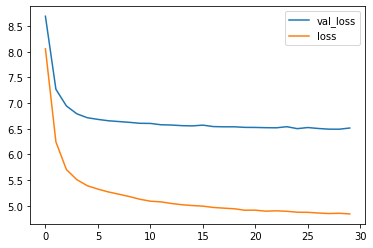

In [35]:
pd.DataFrame(new_lstm_model.history.history).plot()

In [36]:
mean_absolute_error(y_dev, new_lstm_model.predict(X_dev))

1.509018214967277

We tried a few different architectures randomly and whilst we were able to reduce the dev error we were not able to improve the loss below 6.

## Visualise model predictions

In [37]:
# Flatten all predictions
actual_vs_pred = pd.DataFrame(
    {
        'actual': y_train.flatten(), 
        'predictions': new_lstm_model.predict(X_train).flatten()
    }
)
actual_vs_pred.head()

,actual,predictions
0,0,0.182647
1,0,0.249864
2,6,0.288861
3,0,0.226620
4,1,0.293032


In [38]:
actual_vs_pred['mean'] = actual_vs_pred['actual'].mean()

/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


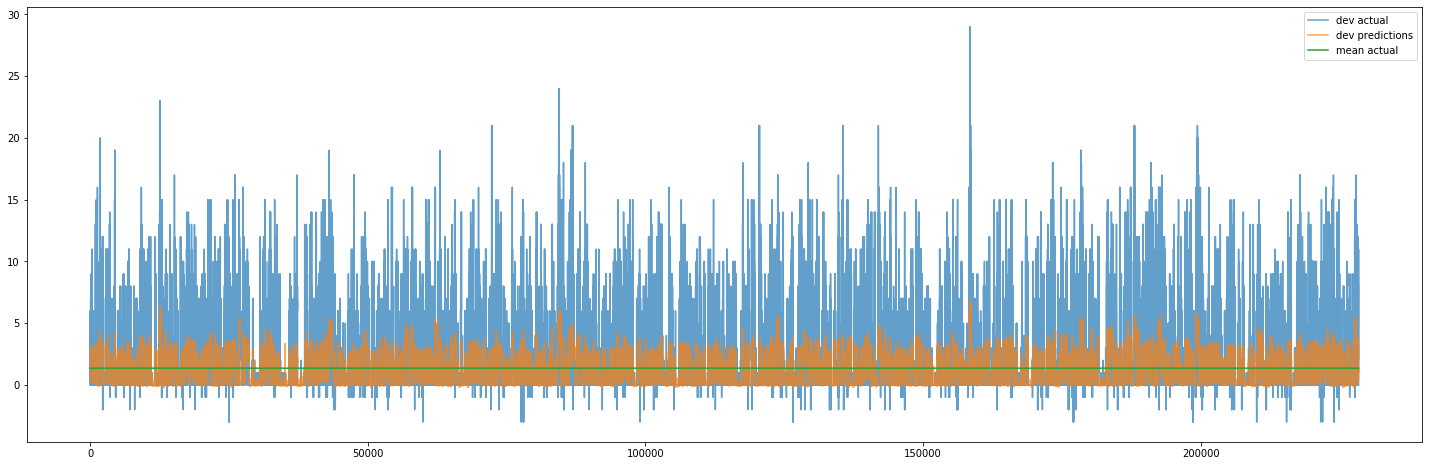

In [39]:
plt.figure(figsize=(25,8))
plt.plot(actual_vs_pred['actual'], alpha=0.7, label='dev actual')
plt.plot(actual_vs_pred['predictions'], alpha=0.7, label='dev predictions')
plt.plot(actual_vs_pred['mean'], label='mean actual')
plt.legend()

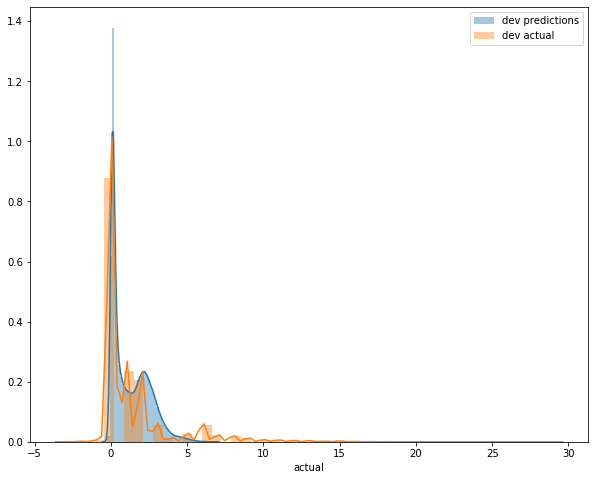

In [40]:
plt.figure(figsize=(10,8))
sns.distplot(actual_vs_pred['predictions'], label='dev predictions')
sns.distplot(actual_vs_pred['actual'], label='dev actual')
plt.legend()

In [41]:
actual_vs_pred['actual'] = actual_vs_pred['actual'].astype(float)
actual_vs_pred.describe()

,actual,predictions,mean
count,228455.000000,228455.000000,228455.000000
mean,1.360636,1.220044,1.360636
std,2.495397,1.198130,0.000000
min,-3.000000,-0.234166,1.360636
25%,0.000000,0.157226,1.360636
50%,0.000000,0.796944,1.360636
75%,2.000000,2.144125,1.360636
max,29.000000,6.759554,1.360636


Model seems to be quite conservative. No predictions greater than 5.9. This will be driving the large MSE.

In [42]:
print(f"Percentage of actuals above max predicted value: {(actual_vs_pred['actual'] > actual_vs_pred['predictions'].max()).sum() / actual_vs_pred.shape[0]}")

Percentage of actuals above max predicted value: 0.05398875051979602


## Learning curve

Does more examples help? If not let's try and get more features.

CPU times: user 24min 15s, sys: 5min 18s, total: 29min 33s
Wall time: 11min 35s


<module 'matplotlib.pyplot' from '/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/matplotlib/pyplot.py'>

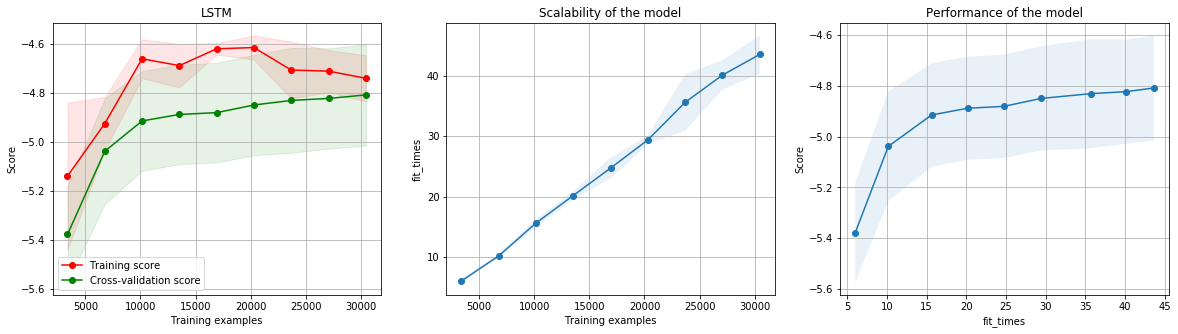

In [85]:
%%time
plot_learning_curve(
    KerasRegressor(build_fn=create_model, epochs=30, batch_size=128, verbose=0),
    'LSTM',
    X_train,
    y_train,
    scoring='neg_mean_squared_error',
    cv=3,
    train_sizes=np.linspace(0,1,10)[1:]
)

__Observations:__
- Model performance on dev set does slope with the number of training examples
- The gap between training and dev also narrows
- Interestingly, the cross-validation MSE is much better, and closer to the train MSE, than what we found earlier.
- Perhaps our dev set is not representative?
- __NO__: It is actually better because CV samples randomly without paying attention to ordering. This leads to data leakage (the model sees (is trained on) some observations which have occured after the observations in the dev set). Learnt this the hard way!

Check features for which we reject the null hypothesis that the disbtribution of the feature values are the same:

## Look more closely at the dev set

Compare distributions of train vs dev:

In [43]:
features_with_distribution_mismatch = []

for col in training_df.select_dtypes(np.number).columns:
    p_value = ks_2samp(training_df[col], dev_df[col])[1]
    if p_value < 0.05:
        features_with_distribution_mismatch.append(col)
print(features_with_distribution_mismatch)

['bps', 'clean_sheets', 'creativity', 'goals_conceded', 'ict_index', 'influence', 'minutes', 'gw', 'selected', 'threat', 'total_points', 'transfers_balance', 'transfers_in', 'transfers_out', 'value', 'promoted_side', 'position_DEF', 'late_kickoff', 'kickoff_month_Aug', 'kickoff_month_Sep', 'kickoff_month_Oct', 'kickoff_month_Mar', 'kickoff_month_Apr', 'season_order', 'next_match_value', 'next_match_kickoff_month_Sep', 'next_match_kickoff_month_Oct', 'next_match_kickoff_month_Mar', 'next_match_kickoff_month_Apr', 'next_match_late_kickoff', 'total_points_plus1_gw']


In [44]:
len(features_with_distribution_mismatch)

31

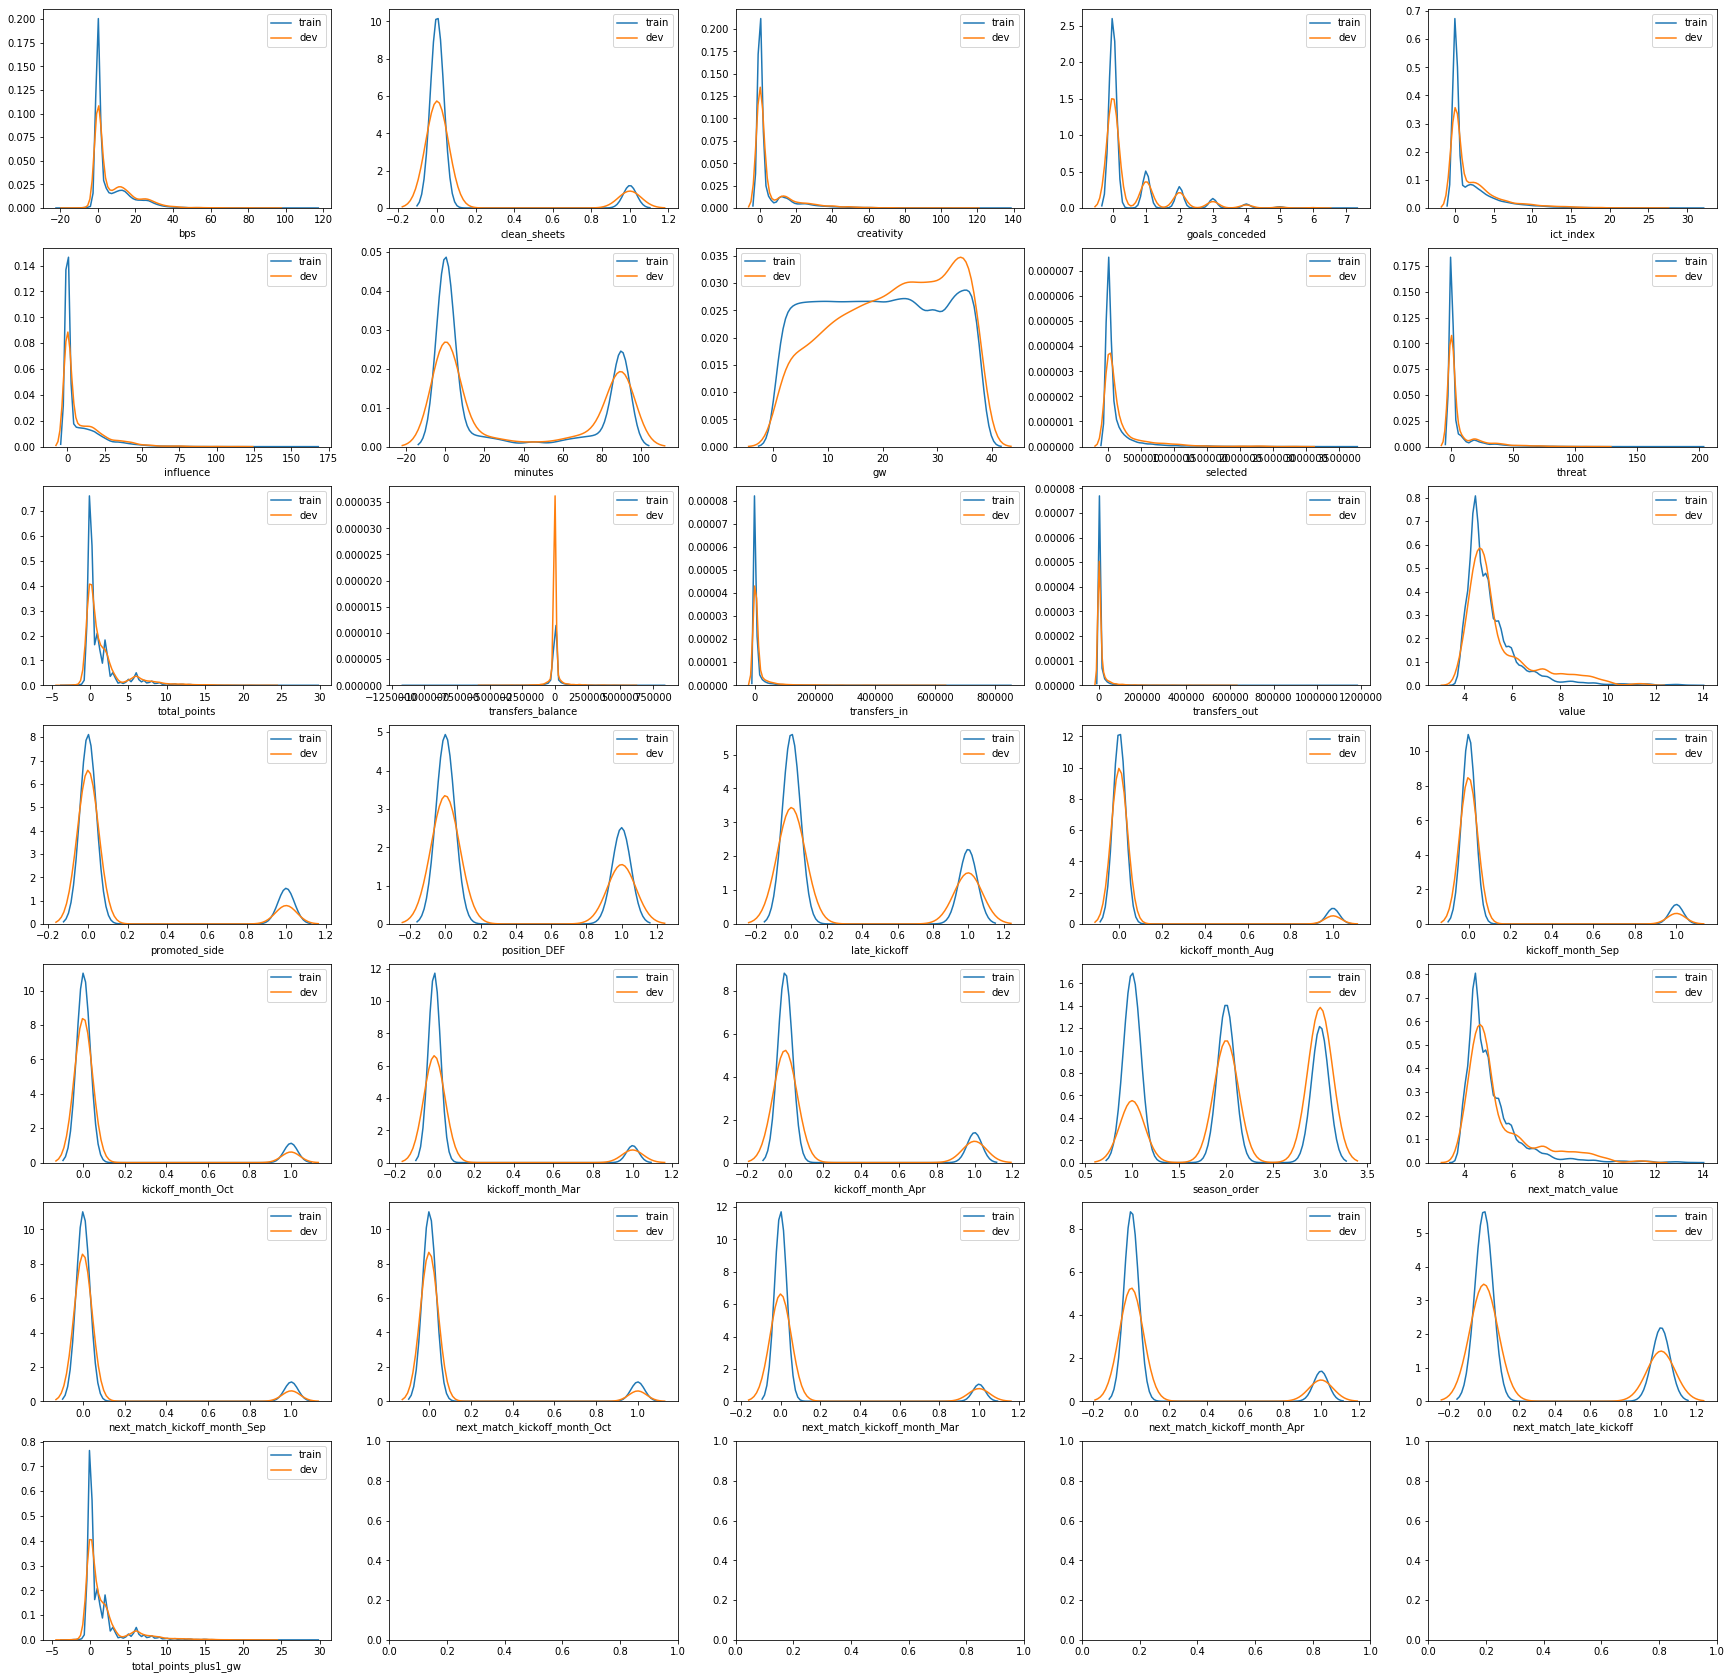

In [45]:
fig, axes =  plt.subplots(7,5)
fig.set_size_inches(30, 30)

grid_position_dict = dict(
    zip(
        range(35),
        list(itertools.product(range(7), range(5)))
    )
)

for i, col in enumerate(features_with_distribution_mismatch):
    ax=axes[grid_position_dict[i][0]][grid_position_dict[i][1]]
    sns.distplot(training_df[col], hist=False, label='train', ax=ax)
    sns.distplot(dev_df[col], hist=False, label='dev', ax=ax)

plt.show()

Text(0, 0.5, '% of total')

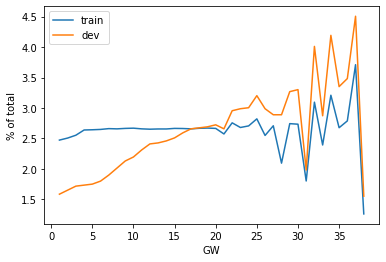

In [71]:
pd.concat(
    [
        pd.DataFrame(training_df['gw'].value_counts().sort_index() / training_df['gw'].value_counts().sum() * 100).rename(columns={'gw': 'train'}),
        pd.DataFrame(dev_df['gw'].value_counts().sort_index() / dev_df['gw'].value_counts().sum() * 100).rename(columns={'gw': 'dev'})
    ],
    axis=1
).plot()
plt.xlabel('GW')
plt.ylabel('% of total')

Dev has much more data in latter GWs than earlier ones. We want our model to perform well across the season so may make more sense to increase the proportion of data in lower GWs for the dev set.

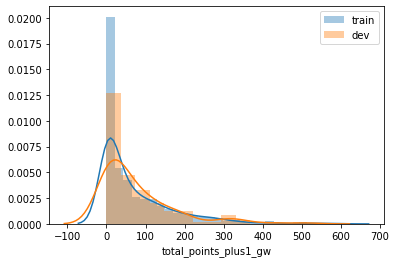

In [77]:
sns.distplot(training_df.groupby('name').sum()['total_points_plus1_gw'], label='train')
sns.distplot(dev_df.groupby('name').sum()['total_points_plus1_gw'], label='dev')
plt.legend()

In [78]:
training_df['total_points_plus1_gw'].max()

29.0

In [80]:
dev_df['total_points_plus1_gw'].max()

23.0

## Do differences in distribution have a significant impact on model performance on unseen data?

A true test set is data from the 2019-20 season. We can see how the model performs on this data to see if we need to revise our problem.

In [81]:
from src.models.LSTM.make_predictions import load_retro_data

In [82]:
new_data = load_retro_data(current_season_data_filepath='data/gw_player_data/gw_29_player_data.parquet')

2020-06-03 17:41:19,757 - Loading raw historical FPL data
2020-06-03 17:41:19,821 - Loaded historical data of shape: (67797, 52)
2020-06-03 17:41:19,876 - Creating season order column
2020-06-03 17:41:19,971 - Generating known features for next GW
2020-06-03 17:41:20,292 - Final input shape: (84295, 68)


In [83]:
new_data['season'].value_counts()

2016-17    23642
2017-18    22467
2018-19    21688
2019-20    16498
Name: season, dtype: int64

In [84]:
new_data['total_points_plus1_gw'] = new_data.groupby(['name'])['total_points'].shift(-1)
new_data = new_data[~new_data['total_points_plus1_gw'].isnull()]  # drop nulls (last gw)

In [85]:
new_data = new_data[new_data['season'] == '2019-20']

In [86]:
new_data_filtered = filter_eligible_players(new_data)
new_data_filtered.shape

/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(15659, 69)

In [87]:
X_new, y_new = prepare_data_for_lstm(new_data_filtered)

/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(10987, 5, 63)
(10987, 5)


In [88]:
mean_squared_error(y_new, current_lstm_model.predict(X_new))

5.0321433330647185

In [89]:
mean_squared_error(y_new, new_lstm_model.predict(X_new))

5.012688665270572

A MSE of 5 on new data isn't terrible

We saw that for a number of features the distributions are statistically different.

Current data split strategy:
- We use the custom function `custom_train_test_split` to split our data into train, test and dev sets.
- This works as follows:
    1. Randomly assign 1s to rows of player DataFrame to create a new column `in_test_set`
    2. Forward fill this column by player such that all future GWs for a randomly selected player are also part of test set
    3. Fill all else with 0s
    4. 1s are in the test set and 0s are in training
- This effectively chops off the most recent GWs for given players. For the majority this will be the final GWs of a given season.
- Our dev set is therefore very different to our training set (end of season vs start of season). By improving performance on the dev set we are only improving performance on the latter GWs whereas we want the model to generalise well across the season.

__Potential changes:__
- We could add entire players to the dev set to get more GW data at ealier points in the season.
- For now keep splitting strategy seems sufficient given performace on unseen 2019-20 data.
- Note: We also explored adding entire players and couldn't improve performance on 2019-20 much more than the current model.
- Bigger issue may be conservative nature of the model.
- Suspect more features are needed for the model to generalise better.

__Other things to explore:__
- How does LGBM do for a single timestep predictions compared to LSTM?
- Permutation feature importance or SHAP to remove features which are irrelevant
- _Note_: For SHAP DeepExplainer may need to use an older version of Keras/Tensorflow